## **LIBRERÍAS NECESARIAS**

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from src.utils import countLabels, EarlyStop, learningLoop
from src.model import MyModel
from src.dataset import MyDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

Usando: cuda


## **PREPROCESADO DE DATOS**

In [2]:
path = "data/train"

t = transforms.Compose([ # Transforms para convertir las imagenes a escala de grises a un tensor
    transforms.Resize((64,64)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

data = datasets.ImageFolder(root=path, transform=t)

In [3]:
print(len(data))
cont = countLabels(data)
print(cont)

41694
{0: 9322, 1: 9929, 2: 12994, 3: 9449}


In [4]:
valIdx = [] # Creamos una lista donde almacenaremos los índices de data usados para el conjunto de validación
testIdx = [] # Creamos una lista donde almacenaremos los índices de data usados para el conjunto de test
targets = torch.tensor(data.targets) # Tensor con la clase de cada imagen

for i in range(4): # Para cada una de las 7 clases
    idx = torch.where(i == targets)[0] # Obtenemos todos los índices del dataset para la clase i
    valIdx.extend(idx[:int(cont[i]*0.1)].tolist()) # Añadimos un 10% de los datos de la clase i a nuestra lista de validación
    testIdx.extend(idx[-int(cont[i]*0.1):].tolist()) # Añadimos otros 10% de los datos de la clase i a nuestra lista de test

trainIdx = [i for i in range(0, len(data)) if i not in set(valIdx) and i not in set(testIdx)] # Obtenemos los nuevos índices de train, excluyendo los datos de validación y test

train = torch.utils.data.Subset(data, trainIdx) # Creamos nuestro nuevo conjunto de train
validation = torch.utils.data.Subset(data, valIdx) # Creamos nuestro conjunto de validación
test = torch.utils.data.Subset(data, testIdx) # Creamos nuestro conjunto de test

In [5]:
print(f"Longitud del nuevo conjunto de train: {len(train)}")
print(f"Longitud del nuevo conjunto de validation: {len(validation)}")
print(f"Longitud del nuevo conjunto de test: {len(test)}")
print(f"Elementos por clase de train: {countLabels(train)}")
print(f"Elementos por clase de validation: {countLabels(validation)}")
print(f"Elementos por clase de test: {countLabels(test)}")

Longitud del nuevo conjunto de train: 33360
Longitud del nuevo conjunto de validation: 4167
Longitud del nuevo conjunto de test: 4167
Elementos por clase de train: {0: 7458, 1: 7945, 2: 10396, 3: 7561}
Elementos por clase de validation: {0: 932, 1: 992, 2: 1299, 3: 944}
Elementos por clase de test: {0: 932, 1: 992, 2: 1299, 3: 944}


In [6]:
train = MyDataset(train) # Creamos nuestros datasets
validation = MyDataset(validation)
test = MyDataset(test)

Clases: ['0: angry', '1: happy', '2: neutral', '3: sad']


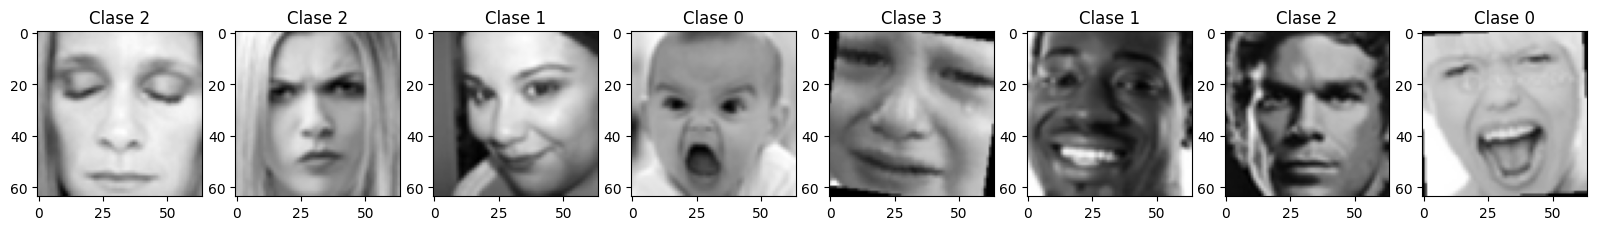

In [7]:
print(f"Clases: {[f'{i}: {data.classes[i]}' for i in range(len(data.classes))]}")

plt.figure(figsize=(20, 5))
randIdx = torch.randint(0, len(train), (8,))
for i, idx in enumerate(randIdx):
    plt.subplot(1, 8, i + 1)
    plt.title(f"Clase {train[idx][1]}")
    plt.imshow(train[idx][0].to("cpu").permute(1, 2, 0), cmap="gray")

plt.show()

## **ENTRENAMIENTO**

In [ ]:
torch.manual_seed(0)

batchSize = 1024
learningRate = 0.005 # Tasa de aprendizaje
epochs = 100
lossFn = nn.CrossEntropyLoss() # Función de pérdida
optimizer = torch.optim.Adam # Optimizador
patience = 5 # Número de épocas límite si no mejora el error
delta = 0.01 # Umbral de error
valFreq = 1 # Frecuencia con la que se valida el entrenamiento (nº de épocas)

trainDataloader = DataLoader(train, batch_size=batchSize, shuffle=True)
valDataloader = DataLoader(validation, batch_size=batchSize, shuffle=False)
testDataloader = DataLoader(test, batch_size=batchSize, shuffle=False)

In [9]:
torch.manual_seed(0)

model = MyModel()
model.to(device)

earlyStop = EarlyStop(patience, delta)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model1, trainLoss, valLoss, acc = learningLoop(trainDataloader, valDataloader, model, epochs, lossFn, learningRate, optimizer, earlyStop, valFreq, device)

Número de parámetros 2237284


epoch:  18%|█▊        | 18/100 [11:56<54:24, 39.81s/it, loss=0.2654556930065155, acc=tensor(0.7555, device='cuda:0')] 

Early stop


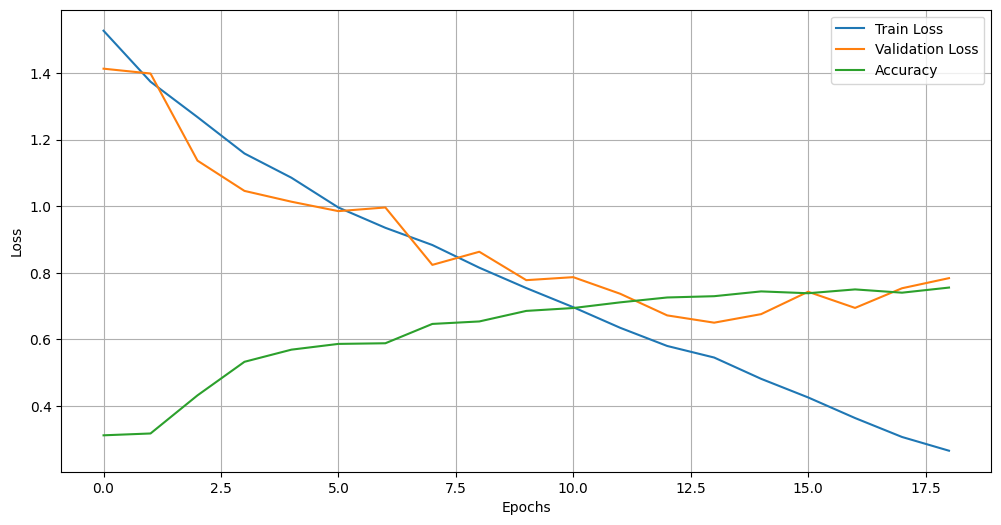

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(trainLoss)), trainLoss, label="Train Loss")
plt.plot(range(0, valFreq * len(valLoss), valFreq), valLoss, label="Validation Loss")
plt.plot(range(0, valFreq * len(acc), valFreq), [i.to("cpu") for i in acc], label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [11]:
path = "models"
torch.save(model1.state_dict(), path+"/model.pth")

## **RESULTADOS DEL TEST**

              precision    recall  f1-score   support

           0       0.79      0.70      0.74       932
           1       0.78      0.77      0.77       992
           2       0.72      0.76      0.74      1299
           3       0.61      0.65      0.63       944

    accuracy                           0.72      4167
   macro avg       0.73      0.72      0.72      4167
weighted avg       0.73      0.72      0.72      4167



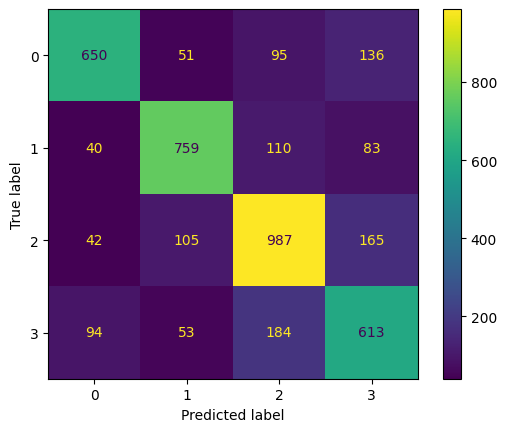

In [12]:
yPred = []
yTest = []
model1.to(device)
model1.eval()
with torch.no_grad():
    for xTestTrue, yTestTrue in testDataloader:
        xTestTrue = xTestTrue.to(device)
        yTestTrue = yTestTrue.to(device)

        yTest.append(yTestTrue)
        yPred.append(model1(xTestTrue))

yPred = torch.argmax(torch.cat(yPred), dim=-1)
yTest = torch.cat(yTest)

print(classification_report(yTest.to("cpu"), yPred.to("cpu")))
cm = confusion_matrix(yTest.to("cpu"), yPred.to("cpu"))
ConfusionMatrixDisplay(cm).plot()